# Earthquake Data Download, Phase Picking, Polarity and Focal Mechanism Determination
This notebook will select earthquake events from the USGS catalogs subset made in part-1 for above slab events.
Then download the `mseed` file and associated `inventory (txt)` files for each events for events in the study area.
Since this is a fairly small study area start time of 30s before the event time will be enough for the most distant ones as well.
Next, I will use `PhaseNet` and `Pyrocko` to pick P and S phases and their polarity.
Lastly, I will use `HASH(fortran)` and `SKHASH (python)` to determine the focal mechanisms.

----------------------------------------------------------------------------------------

### Import all necessary libraries here, this will make things easier later

In [58]:
import os
import sys
import time
from tqdm.auto import tqdm
import glob
# from joblib import Parallel, delayed
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from obspy.clients.fdsn import Client
from obspy import UTCDateTime, read_inventory, Inventory, read, Stream
import matplotlib.pyplot as plt

sys.path.append('./my_funcs')
# %load_ext autoreload
# %autoreload 2
%reload_ext autoreload

# my custom functions
from get_waveforms_parallel_v3 import get_waveforms_parallel, get_station_inventory

# set up the project directory
project_dir = f"{os.getcwd()}/../"
data_dir = os.path.join(project_dir, "data/eq_data")
catalog_dir = os.path.join(data_dir, "1_eq_catalogs")
waveform_dir = os.path.join(data_dir, "2_waveforms")
station_dir = os.path.join(data_dir, "3_station_catalogs")

# (1) Select desired events from the catalog. To get a good spatial distribution I divided the study area into grids of 0.2 degrees.
Now, I select the highest magnitude events from each grid.
Also check if the depth is `artificial` i.e, a given value of 5, 10, 15 or 20 km when depth constrain is bad.

In [59]:
eq_cat_file = os.path.join(catalog_dir, "usgs_3D_gridsort_eq_above_slab2_area.csv")

eqdf = pd.read_csv(eq_cat_file, parse_dates=["time"])
eqdf = eqdf[eqdf.mag >= 2.5].reset_index(drop=True)

In [60]:
# Extract unique grid codes and sort them
unique_grid_codes = np.sort(eqdf['grid_code_3D'].unique())
print(f"Number grids with eq : {len(unique_grid_codes)}")

# create an empty dataframe to store the selected events
selected_eq = pd.DataFrame(columns=eqdf.columns)

# Loop through each grid code and select the event with the highest magnitude
for grid_code in unique_grid_codes:
    temp_df = eqdf[eqdf['grid_code_3D'] == grid_code].sort_values(by='mag', ascending=False)
 
    # Check if there are events in the grid
    if len(temp_df) > 0:
        # print(temp_df[['id', 'mag', 'time']])
        # check the depth values if 0 or 5 or 10 km fixed depth, select the next event
        for i, row in temp_df.iterrows():
            if row['depth'] == 0 or row['depth'] == 5 or row['depth'] == 10:
                print(f"Event {row['id']} has depth {row['depth']} km, selecting next event")
                continue
            else:
                selected_eq = pd.concat([selected_eq, row.to_frame().T], ignore_index=True)
                break

# save the selected events
selected_eq.to_csv(f"{catalog_dir}/selected_eq{len(selected_eq)}.csv", index=False)
print(f"Number of selected events : {len(selected_eq)}")


Number grids with eq : 105
Number of selected events : 105


 # (2) Download the inventory data for the following criterias

Get the station inventory within the study area which recorded this event.\
Use this station inventory data to download earthquake data (`.mseed`) and station data (`.txt` or `.xml` format).\
3-channel data for earthquakes are along x, y and z axis. Usually named as HHE, HHN and HHZ or HH1, HH2, HHZ.\
I want to select the following channels in order. If the 1st one is available, get that one only and stop. If not search for the 2nd one and so on.
1. HH*
2. BH*
3. HN*
4. EH* \
Lastly, of stations within the study area (+0.5 degrees) for each of the selected events.


## 2.1 Make a master inventory file
As we select events from 2008 to end of 2023, a master station inventory with all stations within this timeframe should work for all operations.

In [61]:
sta_df = pd.read_csv(f"{station_dir}/00_station_inventory_master.txt", delimiter='|')
print(sta_df.shape[0])
sta_df.drop_duplicates(subset=['#Network', 'Station', 'Channel'], inplace=True)
print(sta_df.shape[0])

sta_df.to_csv(f"{station_dir}/00_station_inventory_master_cleaned.txt", index=False, sep='|')

5145
1089


# (3) Read the inventory files already downloaded 
# And download `.mseed` [and (optional) station_data (`.xml` &/or `.txt`)]

Here I will read the inventory file which contain details about all the stations that recorded a particular earthquake event. \
From that inventory file I will get all the necessary informations I need to download the seismic data (a numpy timeseries in `.mseed` format). \
I will also download the metadata for that record in `.xml & .txt` formats.\

This process will use `multiprocessing.Pool.imap_unordered` module for paraller processing of the download.\
For the code see `./code/my_funcs/get_waveforms_parallel_v3.py` where I defined the download fuction combined with parallel processing. \
This significantly improves the runtime.


client_list = ['IRIS', 'NCEDC', 'SCEDC']
channels_string = 'HH*,BH*,HN*,EH*'                   # by default given to get_waveforms_parallel function
priority_channels = ['HH*', 'BH*', 'HN*', 'EH*']

In [62]:
# get a list of mseed files without folder names
mseed_files = [os.path.basename(f) for f in glob.glob(f"{waveform_dir}/*.mseed")]

progress_bar = tqdm(total=len(selected_eq), desc="Downloading events", dynamic_ncols=True)
for i, row in selected_eq.iterrows():
    event_id = row.id

    # check if the event data is already downloaded
    if f"{event_id}.mseed" in mseed_files:
        progress_bar.update(1)
        continue

    event_time = UTCDateTime(pd.to_datetime(row.time))
    starttime = event_time - 30
    endtime = event_time + 120

    xml_file = f"{waveform_dir}/xml/{event_id}_event_inv.xml"
    if os.path.exists(xml_file):
        inv = read_inventory(xml_file)

    else:
        inv = get_station_inventory(starttime, endtime) # client_list, priority_channels are default
        inv.write(xml_file, format="STATIONXML")
        inv = read_inventory(xml_file)
    
    # get the waveforms for the event and save them
    st, inv = get_waveforms_parallel(starttime, endtime, inventory=inv) # client_list, priority_channels are default

    if len(st) > 0:
        st.write(f"{waveform_dir}/{event_id}.mseed", format="MSEED")
        # inv.write(f"{waveform_dir}/{event_id}_event_inv.txt", format="STATIONTXT")
        # remove the inventory file
        os.remove(xml_file)
        print(f"Download complete for {event_id}:len(st)")
        progress_bar.update(1)

    else:
        progress_bar.update(1)
        continue

## (4.1) Use `Phasenet` to pick P and S phases
An example of phasenet terminal code is: \
`python phasenet/predict.py --model=model/190703-214543 --data_list=test_data/mseed.csv --data_dir=test_data/mseed --format=mseed --result_dir./phasenet_results --result_fname=phasenet_phasepick_datetime.csv`

___[[for more details]](https://github.com/AI4EPS/PhaseNet/blob/master/docs/example_batch_prediction.ipynb)

### 4.1.1 Make a folder to store the results
- Also make a list of .mseed files (only filename for phasenet) and put it in a .csv file

In [69]:
# phasenet_diting_others directory, ****** all paths are absolute paths + relative to cwd at the same time ******
pn_dt_dir = os.path.join(project_dir, "results/phasenet_diting_others")
pn_dir = os.path.join(pn_dt_dir, "phasenet_files")
# make a folder to store the results
os.makedirs(pn_dir, exist_ok=True)

cwd = os.getcwd()
path2 = '/Users/mdaislam/Library/CloudStorage/OneDrive-IndianaUniversity/Research/Software_docs/PhaseNet/'
# relative path from path1 to path2
rel_path = os.path.relpath(path2, cwd)
print(rel_path)
phasenet_path = f"{cwd}/{rel_path}" # path to source code of PhaseNet

# Make a list of .mseed files into a csv file to input into PhaseNet command line
mseed_list = [os.path.basename(fname) for fname in glob.glob(f"{waveform_dir}/*.mseed")]

# Write the list to a csv file
pd.DataFrame(mseed_list, columns=["fname"]).to_csv(f"{pn_dir}/mseed_list.csv", index=False, header=True)

../../../../Software_docs/PhaseNet


### 4.1.2 Make a bash script for running Phasenet

In [65]:

# form_datetime = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")

# Make a script to run PhaseNet 
# *** VVI: every directory is with respect to the location of this notebook ***

script_content = f"""#!/bin/bash

# Change directory into PhaseNet
cd {phasenet_path}

# Activate conda pythoon environment named 'phasenet' [********change miniconda3 to anaconda3 if using Anaconda]
source ~/anaconda3/etc/profile.d/conda.sh
conda activate phasenet

# Run Phasenet prediction
python phasenet/predict.py \\
  --model=model/190703-214543 \\
  --data_list={pn_dir}/mseed_list.csv \\
  --data_dir={waveform_dir} \\
  --format=mseed \\
  --amplitude \\
  --batch_size=1 \\
  --sampling_rate=100 \\
  --result_dir={pn_dir} \\
  --result_fname=phasenet_phasepick_3d_grid \\
  --min_p_prob=0.75 \\
  --min_s_prob=0.85 \\
  # --add_polarity \\
  # --plot_figure

# Deactivate virtual environment (optional)
# conda deactivate

"""

# Write the script content to a file
with open(f"{pn_dir}/run_phasenet.sh", "w") as f:
    f.write(script_content)

# Make the script executable
print("Making the script executable...")
os.system(f"chmod +x {pn_dir}/run_phasenet.sh")

Making the script executable...


0

In [66]:
# print(script_content)

### 4.1.3 Run Phasenet script:
If it's already run, it will ask if you want to run again.

In [67]:
# Run the script
run = True
if run:
    print("Running PhaseNet...")
    os.system(f"{pn_dir}/run_phasenet.sh")
else:
    print("PhaseNet already run. Skipping...")

Running PhaseNet...


2024-03-21 14:24:42,657 Pred log: /Users/mdaislam/Library/CloudStorage/OneDrive-IndianaUniversity/Research/Github/FM2STRESS/FM2STRESS_project/code/../results/phasenet_diting_others/phasenet_files
2024-03-21 14:24:42,657 Dataset size: 112
2024-03-21 14:24:42,738 Model: depths 5, filters 8, filter size 7x1, pool size: 4x1, dilation rate: 1x1
2024-03-21 14:24:42.870900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'create_inputs/is_training' with dtype bool
	 [[{{node create_inputs/is_training}}]]
2024-03-21 14:24:42.880215: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'create_inputs/is_training' with dtype bool
	 [[{

Done with 4015 P-picks and 369 S-picks


**important**
on mac m1, there is no CUDA support (NVIDIA), so in EQNet-master/predict.py (most probably) set `torch.device('cpu') and search args.device and in each function add `args.device = 'cpy'` to use cpu focefully instead of GPU

# 5. Plot the phasenet picks on the seismic data


In [ ]:
def get_sta_dist(folder_station, eid, elat, elon):
    """
    For plotting
    folder_station: folder containing station information (such as ../data/eq_data/event_id/)
    input: event id, event latitude, event longitude
    output: dataframe containing
        - station names
        - distances
        - station latitude
        - station longitude
    """
    from geopy.distance import geodesic

    sta_file = f"{folder_station}/{eid}_event_inv.txt"

    # read station inventory file
    sta_df = pd.read_csv(sta_file, 
                        sep='|', 
                        header=0,
                        usecols=[1, 4, 5]) # Station|Latitude|Longitude    
    # keep only unique station names
    sta_df = sta_df.drop_duplicates(subset=['Station'])

    stanames, slat, slon = sta_df['Station'].values, sta_df['Latitude'].values, sta_df['Longitude'].values
    distances = []
    for i in range(0, len(sta_df)):
        distances.append(geodesic((elat, elon), (slat[i], slon[i])).km)
    distances = np.array(distances)

    # make a dataframe to return 
    df = pd.DataFrame()
    df['stanames'] = stanames
    df['distances'] = distances
    df['slat'] = slat
    df['slon'] = slon
    df = df.sort_values(by='distances', ascending=True).reset_index(drop=True)
    return df



def get_phasenet_phasepicks(phasenet_file, eid):
    """
    Get the phase picks from the PhaseNet output file for a given event id
    """

    df = pd.read_csv(phasenet_file, header=0, parse_dates=['phase_time'])
    subdf = df.loc[df.file_name.str.split('.').str[0]==eid,:]
    subdf.loc[:, 'station_id'] = subdf.station_id.str.split('.').str[1]

    subdf2 = subdf.loc[:, ['station_id', 'phase_time', 'phase_type']]
    subdf2.phase_time = pd.to_datetime(subdf2.phase_time)

    return subdf2

/var/folders/vr/bxyph_y13z17gzq1r_gst6zw0000gn/T/ipykernel_5053/2082096629.py:38: RuntimeWarning: invalid value encountered in divide
  tr.data = tr.data/np.max(tr.data)
/var/folders/vr/bxyph_y13z17gzq1r_gst6zw0000gn/T/ipykernel_5053/2082096629.py:38: RuntimeWarning: invalid value encountered in divide
  tr.data = tr.data/np.max(tr.data)


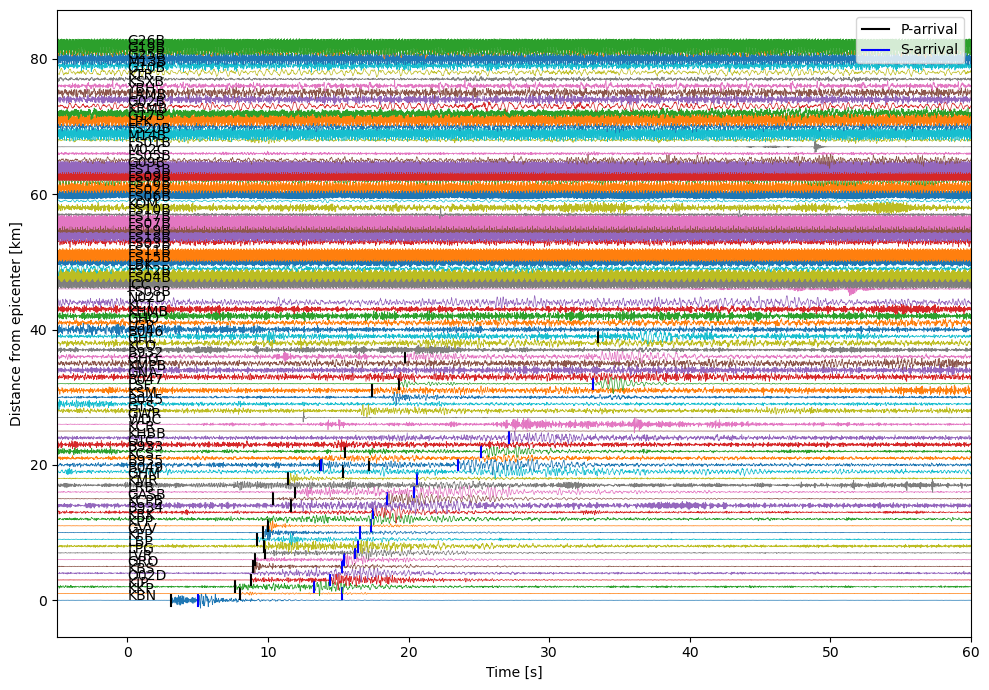

In [ ]:
mseed = f'{data_path}/{mseed_list[0]}'

row = selected_eq.loc[selected_eq.id == mseed_list[0].split('.')[0]]
eid, elat, elon, emag, edepth = row.id.values[0], row.latitude.values[0], row.longitude.values[0], row.mag.values[0], row.depth.values[0]
t_origin = UTCDateTime(pd.to_datetime(row.time.values[0]))

sta_df = get_sta_dist(f"{data_path}", eid, elat, elon)
stnames, stdist, slat, slon = sta_df['stanames'].values, sta_df['distances'].values, sta_df['slat'].values, sta_df['slon'].values
phase_picks = get_phasenet_phasepicks(f"{data_path}/phasenet_files/phasenet_phasepick_datetime.csv", eid)

# Read the mseed file
st = read(mseed)

# Plot the waveform
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1,1,1)

for i in range(len(stnames)):
    sta = str(stnames[i])
    temp_st = st.select(station=sta)
    temp_st2 = temp_st.select(component='Z')

    tr = temp_st[0]
    tr.detrend('demean')
    tr.filter('bandpass', freqmin=2, freqmax=20)
    tr.taper(0.05)
    tr.data = tr.data/np.max(tr.data)

    # time array
    t = (tr.stats.starttime-t_origin) + np.arange(0, tr.stats.npts)/tr.stats.sampling_rate

    # plot waveform, lw is linewidth
    ax.plot(t, tr.data+i, lw=0.5)

    # plot P and S arrivals
    filtered_data = phase_picks.loc[phase_picks.station_id == sta]  # Filter for the station ID once

    for index, row in filtered_data.iterrows():
        phase_type = row['phase_type']
        phase_time_temp = UTCDateTime(row['phase_time'])
        dt = phase_time_temp - t_origin

        if phase_type == 'P':
            ax.plot([dt, dt], [i - 0.8, i + 0.8], 'k', label='P-arrival' if i == 0 else None)
        elif phase_type == 'S':
            ax.plot([dt, dt], [i - 0.8, i + 0.8], 'b', label='S-arrival' if i == 0 else None)

    # plot station name
    ax.text(0, i, sta)  

ax.legend(loc='upper right')
ax.set_xlim([-5, 60])
ax.set_xlabel('Time [s]')
ax.set_ylabel('Distance from epicenter [km]')
plt.tight_layout()
plt.show()


/Users/mdaislam/anaconda3/envs/obspy/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/Users/mdaislam/anaconda3/envs/obspy/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


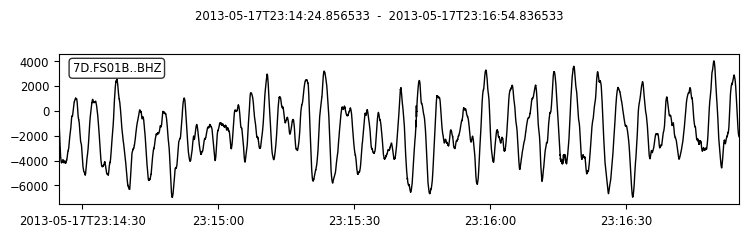

In [ ]:
picks = pd.read_csv(f"{data_path}/phasenet_files/phasenet_phasepick_datetime.csv", parse_dates=["phase_time"])
mseed = f'{data_path}/{mseed_list[0]}'
event_id = mseed_list[0].split('.')[0]

stream = read(mseed)
## Extract 3-component data and select 'Z' channel
stream = stream.sort()
stream = stream.select(component="Z")

stream[0].plot();

# (4.2) Use GAMMA for associationa and determining phase polarity

!pip install git+https://github.com/wayneweiqiang/GaMMA.git